In [1]:
# Append the parent directory to the path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

# Import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.regression.linear_model import OLS
import pickle
from tqdm import tqdm

In [2]:
# Import custom classes and functions
from environments.base import BaseEnvironment, SimpleBilateralEnvironment
from environments.contextual import ContextualEnvironment, OrderBookEnvironment 
from learners.experts import GFTMax, ContextualGFTMax, EDLV, FastEDLV, FastEDLV2
from learners.bandits import TwoBitsEDLV, OneBitEDLV
from utils.regret import compute_scaling_laws, compute_scaling_laws_with_policy_regret
from utils.valuations import construct_sequence_with_lipschitz_valuations, construct_logarithmic_lower_bound

# Bilateral trade with experts - base setting

In [11]:
T = 100000 # Best expert over 100 Million turns is computed in less than a minute
env = SimpleBilateralEnvironment(T)
print(env.get_best_expert())

((0.75, 1.0), 12579.5)


In [15]:
T = 100000
env = SimpleBilateralEnvironment(T)
learner = GFTMax(T, env)
learner.run()

print(learner.get_final_gft())
print(env.get_best_expert()[1])

12276.75
12506.75


In [ ]:
time = np.linspace(1000, 100000, 20)

# Define the function in the global scope
def compute_regret():
    _, _, regret = compute_scaling_laws(GFTMax, SimpleBilateralEnvironment, time)
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [93]:
# with open('../data/gftmax_regrets.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/gftmax_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [28]:
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)
mean = np.mean(regrets, axis=0)

In [74]:
y = np.hstack(regrets)
X = np.tile(np.linspace(1000, 100000, 20, dtype=int), num_iterations)
X_sqrt = np.sqrt(X).reshape(-1, 1)

reg = LinearRegression().fit(X_sqrt, y)
print(f"R^2: {reg.score(X_sqrt, y)}")
print(f"Coefficient: {reg.coef_[0]}")
print(f"Intercept: {reg.intercept_}")

R^2: 0.8042409249001073
Coefficient: 0.7826947740212187
Intercept: 12.557676497467071


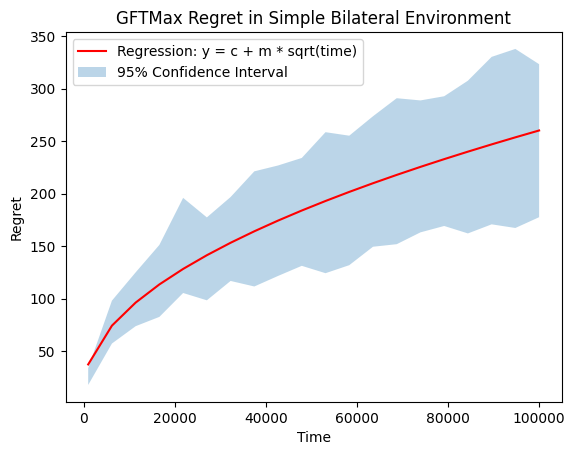

In [91]:
# Plot the regrets
plt.figure()
plt.plot(time, reg.predict(X_sqrt[:20]), label='Regression: y = c + m * sqrt(time)', color='red')
plt.fill_between(time, upper_bound, lower_bound, alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('GFTMax Regret in Simple Bilateral Environment')
plt.legend()
plt.show()

# Bilateral trade with experts - contextual setting

## Sinusoidal valuations

In [3]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
print(env.get_policy_gft_having_adhoc_valuations())

8315.686126078102


### Contextual GFTMax

This algorithm is a variation of the GFTMax algorithm: when the context does not allow to execute the sampled action, the action and all the other experts get rescaled inside the allowed limits - which are defined, again, by the context.

In [6]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = ContextualGFTMax(T, env)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

1859.6286099583554
8349.332640261933


In [8]:
time = np.linspace(100, 10000, 10, dtype=int)
L_constants = np.linspace(5, 100, 5)

# Some parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ContextualGFTMax, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [9]:
with open('../data/contextualgftmax_regrets.pkl', 'wb') as f:
    pickle.dump(regrets, f)
# with open('../data/contextualgftmax_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [10]:
regrets = np.array(regrets)
print(regrets.shape)

(100, 10, 5)


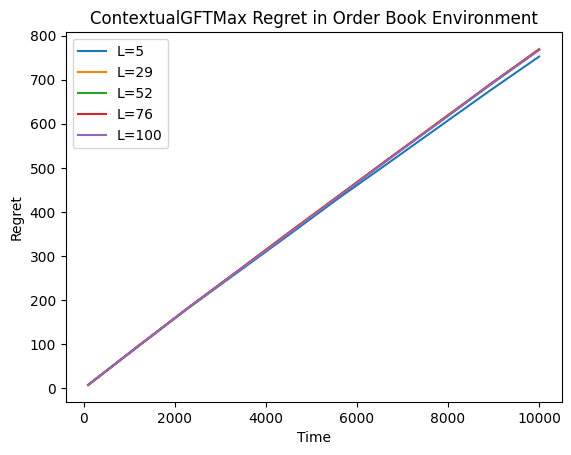

In [11]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('ContextualGFTMax Regret in Order Book Environment')
plt.legend()
plt.show()

Well... this algorithm clearly does not work.

### Estimate Deterministic Lipschitz Valuations

In [4]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = EDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [01:44<00:00, 960.18it/s] 

8288.565565094463
8322.654809322916


This is a low regret. However, the algorithm is slow. We reduce the supremum on the time horizon set from 10^5 to 10^4.

In [ ]:
time = np.logspace(start=1, stop=4, num=10, base=10, dtype=int)
L_constants = np.linspace(10, 200, 10, dtype=int)

# Some parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        EDLV, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [14]:
# with open('../data/edlv_regrets4.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/edlv_regrets4.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [15]:
regrets = np.array(regrets)
regrets.shape

(100, 10, 10)

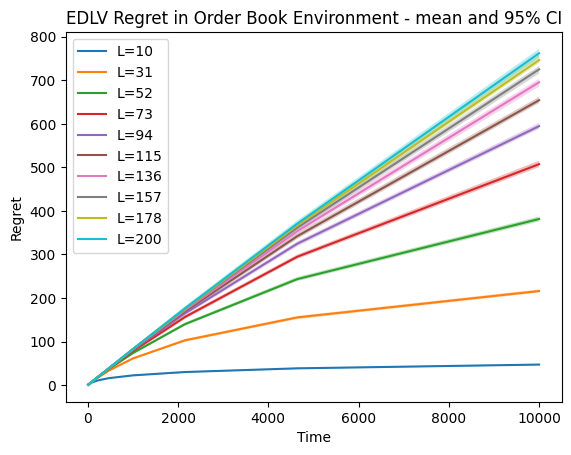

In [16]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

The regret here is 0 because of how the valuations are constructed: s upper bound and b lower bound overlap in the middle point.

In [17]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")


Regression with time and log(time)
R^2: 0.98
Coefficient for time: 0.0
Coefficient for log(time): 4.95
Intercept: -14.01

Regression with time, log(time) and sqrt(time)
R^2: 1.0
Coefficient for time: -0.0
Coefficient for log(time): 0.75
Coefficient for sqrt(time): 0.75
Intercept: -3.85


In [18]:
# Regress the regrets onto time and Lipschitz constant

# Create a meshgrid of time and L_constants
x_mesh = np.meshgrid(L_constants, time)
X = np.stack([x_mesh[0], x_mesh[1]], axis=2)
X = np.tile(X, (num_iterations, 1, 1, 1))

# Delete the rows where L >= time
# mask = X[:, :, :, 0] < X[:, :, :, 1]

# Introduce interaction terms
# X_inter = X[:, :, :, 0] * X[:, :, :, 1]
# X = np.concatenate([X, np.expand_dims(X_inter, -1)], axis=3)

# Take the log, sqrt, power of two of the features
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X_sq = X[:, :, :, 0, np.newaxis] ** 2
X = np.concatenate([X, X_log, X_sqrt, X_sq], axis=3)

# Add L/log(T), L*log(T), L*T, L*sqr(T), sqrt(L)*T
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] / np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * X[:, :, :, 1, np.newaxis])], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.sqrt(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (np.sqrt(X[:, :, :, 0, np.newaxis]) * X[:, :, :, 1, np.newaxis])], axis=3)

# X = X[mask]
# y = regrets[mask]
y = regrets

X = X.reshape(-1, 12)
y = y.reshape(-1)

# Remove time (idx 1)
X = X[:, ([i for i in range(12) if i != 1])]

vars = ["L", "log(L)", "log(time)", "sqrt(L)", "sqrt(time)", "L^2", "L/log(T)", "L*log(T)", "L*T", "L*sqrt(T)", "sqrt(L)*T"]
print(X.shape, y.shape)

(10000, 11) (10000,)


In [19]:
# Fit the regression - coefficients set as non-negative
reg = LinearRegression(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")


R^2: 0.98
Coefficient for L: 0.0
Coefficient for log(L): 4.74
Coefficient for log(time): 3.39
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 0.0
Coefficient for sqrt(L)*T: 0.01
Intercept: -31.16


In [20]:
# Rescale the features and fit Lasso - coefficients set as non-negative
X = (X - X.mean(axis=0)) / X.std(axis=0)
reg = Lasso(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.98
Coefficient for L: 0.0
Coefficient for log(L): 2.21
Coefficient for log(time): 5.16
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 11.41
Coefficient for sqrt(L)*T: 166.77
Intercept: 110.35


We leave the model discovery for another time. However, we could try a genetic algorithm. 

## Logarithmic lower bound

10.762977600097656


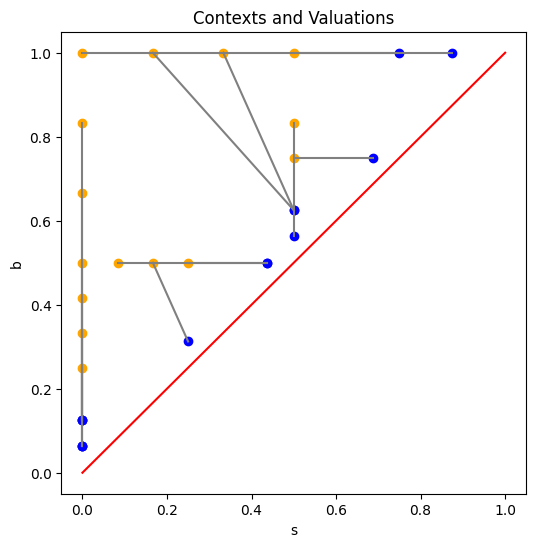

In [12]:
T = 100000
order_book, valuation_sequence = construct_logarithmic_lower_bound(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
print(env.get_policy_gft_having_adhoc_valuations())

# Plot the first 10 elements of the valuation sequence
plt.figure(figsize=(6, 6))
plt.scatter(order_book[:15, 0], order_book[:15, 1], color="orange")
plt.scatter(valuation_sequence[:15, 0], valuation_sequence[:15, 1], color="blue")
# connect each pair of order book and valuation sequence with an arrow
for i in range(15):
    plt.plot([order_book[i, 0], valuation_sequence[i, 0]], [order_book[i, 1], valuation_sequence[i, 1]], color='grey')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('s')
plt.ylabel('b')
plt.title('Contexts and Valuations')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

### Estimate Deterministic Lipschitz Valuations

In [33]:
T = 100000
order_book, valuation_sequence = construct_logarithmic_lower_bound(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = EDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [01:42<00:00, 980.09it/s] 

1.7657852172851562
10.762977600097656


In [22]:
time = np.logspace(start=1, stop=4, num=10, base=10, dtype=int)
L_constants = np.linspace(10, 500, 10, dtype=int)

# Some parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        EDLV, OrderBookEnvironment, time, L_constants, 
        construct_logarithmic_lower_bound
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

100%|██████████| 99/99 [00:00<00:00, 24650.41it/s]s]

100%|██████████| 2153/2153 [00:00<00:00, 9804.86it/s] 

100%|██████████| 2153/2153 [00:00<00:00, 9998.70it/s] 

100%|██████████| 2153/2153 [00:00<00:00, 8832.28it/s] 

100%|██████████| 9999/9999 [00:01<00:00, 6768.91it/s] 


In [23]:
# with open('../data/edlv_log_regrets2.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/edlv_log_regrets2.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [24]:
regrets = np.array(regrets)
regrets.shape

(100, 10, 10)

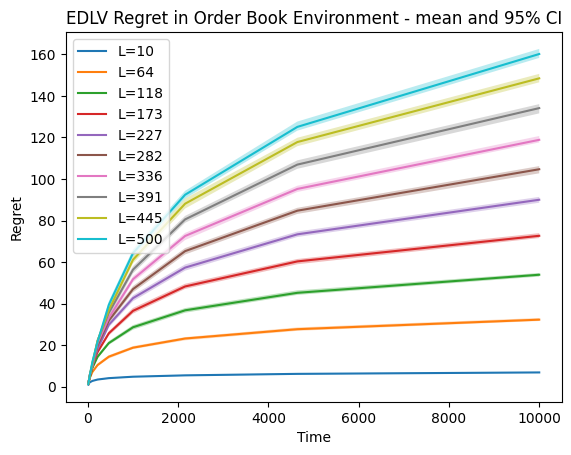

In [25]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

In [26]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")


Regression with time and log(time)
R^2: 1.0
Coefficient for time: 0.0
Coefficient for log(time): 0.83
Intercept: -0.96

Regression with time, log(time) and sqrt(time)
R^2: 1.0
Coefficient for time: -0.0
Coefficient for log(time): 0.76
Coefficient for sqrt(time): 0.01
Intercept: -0.79


In [27]:
# Regress the regrets onto time and Lipschitz constant

# Create a meshgrid of time and L_constants
x_mesh = np.meshgrid(L_constants, time)
X = np.stack([x_mesh[0], x_mesh[1]], axis=2)
X = np.tile(X, (num_iterations, 1, 1, 1))

# Delete the rows where L >= time
# mask = X[:, :, :, 0] < X[:, :, :, 1]

# Introduce interaction terms
# X_inter = X[:, :, :, 0] * X[:, :, :, 1]
# X = np.concatenate([X, np.expand_dims(X_inter, -1)], axis=3)

# Take the log, sqrt, power of two of the features
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X_sq = X[:, :, :, 0, np.newaxis] ** 2
X = np.concatenate([X, X_log, X_sqrt, X_sq], axis=3)

# Add L/log(T), L*log(T), L*T, L*sqr(T), sqrt(L)*T
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] / np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.log(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * X[:, :, :, 1, np.newaxis])], axis=3)
X = np.concatenate([X, (X[:, :, :, 0, np.newaxis] * np.sqrt(X[:, :, :, 1, np.newaxis]))], axis=3)
X = np.concatenate([X, (np.sqrt(X[:, :, :, 0, np.newaxis]) * X[:, :, :, 1, np.newaxis])], axis=3)

# X = X[mask]
# y = regrets[mask]
y = regrets

X = X.reshape(-1, 12)
y = y.reshape(-1)

# Remove time (idx 1)
X = X[:, ([i for i in range(12) if i != 1])]

vars = ["L", "log(L)", "log(time)", "sqrt(L)", "sqrt(time)", "L^2", "L/log(T)", "L*log(T)", "L*T", "L*sqrt(T)", "sqrt(L)*T"]
print(X.shape, y.shape)

(10000, 11) (10000,)


In [28]:
# Fit the regression - coefficients set as non-negative
reg = LinearRegression(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.98
Coefficient for L: 0.0
Coefficient for log(L): 1.41
Coefficient for log(time): 3.75
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.0
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 0.0
Coefficient for sqrt(L)*T: 0.0
Intercept: -19.52


In [29]:
# Rescale the features and fit Lasso - coefficients set as non-negative
X = (X - X.mean(axis=0)) / X.std(axis=0)
reg = Lasso(positive=True).fit(X, y)
print(f"R^2: {round(reg.score(X, y), 2)}")
for i, coef in enumerate(vars):
    print(f"Coefficient for {coef}: {round(reg.coef_[i], 2)}")
print(f"Intercept: {round(reg.intercept_, 2)}")

R^2: 0.98
Coefficient for L: 0.0
Coefficient for log(L): 0.36
Coefficient for log(time): 7.07
Coefficient for sqrt(L): 0.0
Coefficient for sqrt(time): 0.0
Coefficient for L^2: 0.0
Coefficient for L/log(T): 0.0
Coefficient for L*log(T): 0.26
Coefficient for L*T: 0.0
Coefficient for L*sqrt(T): 30.86
Coefficient for sqrt(L)*T: 0.0
Intercept: 32.72


## A faster EDLV?

This new algorithm should be faster than the original one because it is based on k-d trees.

In [ ]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = FastEDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

I should probably call it "Slow EDLV", since it is much slower.

Let's now try the second version of the algorithm, where we only retrieve the nearest neighbor.

In [3]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = FastEDLV2(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [00:04<00:00, 22452.40it/s]

8302.164635280893
8336.695971732806


Wow! But this only works in the experts setting, since for the contextual setting we would still need to calculate every distance at each turn.

# Bilateral trade with bandits - contextual setting

## Sinusoidal valuations

### Estimate Deterministic Lipschitz Valutations - two bits

In [5]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = TwoBitsEDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [02:18<00:00, 722.63it/s] 

8157.723738678838
8307.194679091517


Regret looks fairly low, let us see how it evolves over time. Luckily the code is not as slow as I thought.

In [ ]:
time = np.logspace(start=1, stop=4, num=5, base=10, dtype=int)
L_constants = np.logspace(start=1, stop=2, num=5, base=10, dtype=int)

# Some parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        TwoBitsEDLV, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [17]:
# with open('../data/twobitsedlv_regrets.pkl', 'wb') as f:
#     pickle.dump(regrets, f)
# with open('../data/twobitsedlv_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [18]:
regrets = np.array(regrets)
regrets.shape

(100, 5, 5)

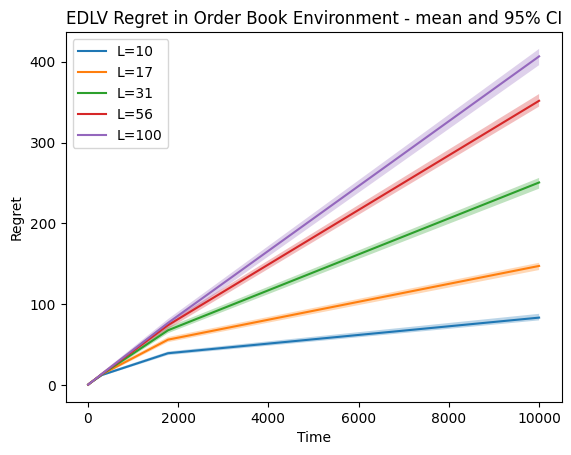

In [19]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

In [20]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")

Regression with time and log(time)
R^2: 0.98
Coefficient for time: 0.0
Coefficient for log(time): 5.47
Intercept: -15.97

Regression with time, log(time) and sqrt(time)
R^2: 1.0
Coefficient for time: -0.01
Coefficient for log(time): -2.9
Coefficient for sqrt(time): 1.62
Intercept: 2.19


## Estimate Deterministic Lipschitz Valuations - one bit

In [10]:
T = 100000
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(T, Lipschitz_constant=10)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
learner = OneBitEDLV(T, env, L=10)
learner.run()

print(learner.get_final_gft())
print(env.get_policy_gft_having_adhoc_valuations())

100%|██████████| 99999/99999 [02:09<00:00, 774.88it/s] 

5346.513431007309
8339.068615764709


In [15]:
time = np.logspace(start=1, stop=4, num=5, base=10, dtype=int)
L_constants = np.logspace(start=1, stop=2, num=5, base=10, dtype=int)

# Some parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        OneBitEDLV, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations
        )
    return regret

num_iterations = 100
regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

100%|██████████| 9999/9999 [00:03<00:00, 2712.27it/s]

100%|██████████| 9999/9999 [00:02<00:00, 4994.71it/s] 


In [16]:
with open('../data/onebitsedlv_regrets.pkl', 'wb') as f:
    pickle.dump(regrets, f)
# with open('../data/twobitsedlv_regrets.pkl', 'rb') as f:
#     regrets = pickle.load(f)

In [17]:
regrets = np.array(regrets)
regrets.shape

(100, 5, 5)

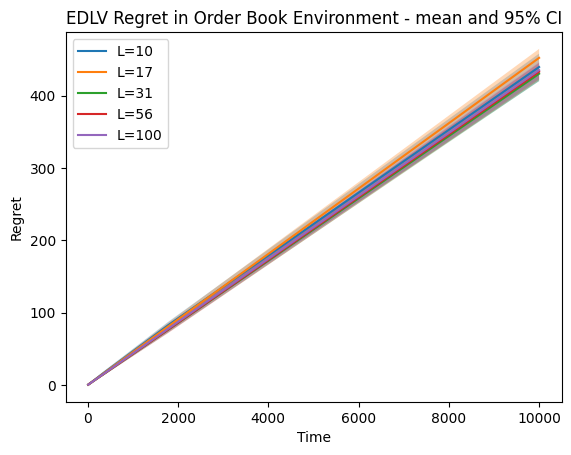

In [18]:
# Calculate the mean of each run
means = np.mean(regrets, axis=0)
# Calculate the 95% confidence interval
upper_bound = np.percentile(regrets, 97.5, axis=0)
lower_bound = np.percentile(regrets, 2.5, axis=0)

# Plot the mean of the regrets per L against time
plt.figure()
for i, L in enumerate(L_constants):
    plt.plot(time, means[:, i], label=f'L={round(L)}')
    plt.fill_between(time, upper_bound[:, i], lower_bound[:, i], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('EDLV Regret in Order Book Environment - mean and 95% CI')
plt.legend()
plt.show()

In [19]:
# Fit regression for L=10
y = regrets[:, :, 0].reshape(-1, 1)
X = np.tile(time, num_iterations).reshape(-1, 1)
X_log = np.log(X)
X_sqrt = np.sqrt(X)
X1 = np.hstack([X, X_log])
X2 = np.hstack([X, X_log, X_sqrt])

reg = LinearRegression().fit(X1, y)
print(f"Regression with time and log(time)")
print(f"R^2: {round(reg.score(X1, y), 2)}")
for i, coef in enumerate(["time", "log(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}\n")

reg = LinearRegression().fit(X2, y)
print(f"Regression with time, log(time) and sqrt(time)")
print(f"R^2: {round(reg.score(X2, y), 2)}")
for i, coef in enumerate(["time", "log(time)", "sqrt(time)"]):
    print(f"Coefficient for {coef}: {round(reg.coef_[0][i], 2)}")
print(f"Intercept: {round(reg.intercept_[0], 2)}")

Regression with time and log(time)
R^2: 1.0
Coefficient for time: 0.04
Coefficient for log(time): 0.92
Intercept: -2.83

Regression with time, log(time) and sqrt(time)
R^2: 1.0
Coefficient for time: 0.04
Coefficient for log(time): -0.97
Coefficient for sqrt(time): 0.37
Intercept: 1.26


# Utils

In [ ]:
# Forward selection with BIC
selected_features = []
selected_feature_indices = []
for i in range(3):
    best_BIC = np.inf
    best_indices = []
    best_var = None
    for j, var in enumerate(vars):
        if var not in selected_features:
            indices = selected_feature_indices + [j]
            X_sub = X[:, indices]
            reg = OLS(y, X_sub).fit()
            BIC = reg.bic
            if BIC < best_BIC:
                best_BIC = BIC
                best_indices = indices
                best_var = var
    selected_features.append(best_var)
    selected_feature_indices = best_indices
    print(f"Selected feature: {best_var}")


# Backward elimination with BIC
prev_BIC = np.inf
while True:
    best_BIC = prev_BIC
    worst_var = None
    best_indices = None
    for i, var in enumerate(vars):
        indices = [j for j, v in enumerate(vars) if v != var]
        model = OLS(y, X[:, indices]).fit()
        BIC = model.bic
        if BIC < best_BIC:
            best_BIC = BIC
            worst_var = var
            best_indices = indices
    if best_BIC < prev_BIC:
        prev_BIC = best_BIC
        print(f"Removing {worst_var} with BIC: {best_BIC}")
        vars.remove(worst_var)
        X = X[:, best_indices]
    else:
        break